In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
import random

In [2]:
df = pd.read_csv("data/default_of_credit_card_clients.csv", skiprows=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [3]:


random.seed()

# rename column to get rid of spaces 

df.rename(columns = {"default payment next month":"default_payment"}, inplace = True)


# split into test and training set 

train_df, test_df = train_test_split(df, test_size=0.2)

X_train, y_train = (train_df.drop(columns=["default_payment"]),
                   train_df["default_payment"])

X_test, y_test = (test_df.drop(columns=["default_payment"]),
                  test_df["default_payment"])


The dataset was split into a 80% training and 20% testing set. The model will be built using only the training data. This gives the abilithy to compute a final performance metric for our model by evaluating it on the testing data. train_test_split() function shuffles the data to ensure the data ending up in the training and test sets is randomized. 

## Exploratory Data Analysis

### Exploring Credit Card Limit Balance

First, we will look at the feature limit balance. Credit card limits are likely an indictor of how wealthy someone is since banks tend to give higher limits to clients that have more money with them. Thus, this may be an important feature when predicting if someone is able to pay the bill on time. 

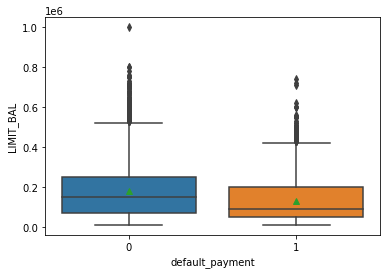

In [4]:
limit_bal = train_df.groupby("default_payment")['LIMIT_BAL'].mean()
sns.boxplot(x = "default_payment", y = "LIMIT_BAL", data = train_df, showmeans=True)
plt.show()

The side-by-side bloxplots above compare credit card limit balance of those who defaulted on their bill next month (class 1) vs those who did not default (class 0). The means are indicated by the green triangles, and the median is shown as the middle line in the box. Looking at the plot indicates that the mean and median is lower for clients who defaulted on the credit card next month. 

In [5]:
pd.DataFrame(limit_bal)

,LIMIT_BAL
default_payment,
0,178356.183443
1,131074.285714


Looking at the above table, we can see that the mean limit balance for clients that did not default on their credit payment (label 0) is higher than the mean limit balance for clients who defaulted on their credit card payment (label 1). 
To test whether this is statistically significant, we can perform a T-test to test the following hypothesis:

$\mathcal{H}_{0}$: the sample means are equal

$\mathcal{H}_{1}$: the sample means are unequal 

Despite not knowing whether the observations are normally distrubuted we can use this according to the central limit theorem because we have a large sample size. 

In [6]:
#select rows where default_payment = 0

default_0 = train_df[train_df["default_payment"] == 0] 

#select rows where default_payment= 1
default_1 = train_df[train_df["default_payment"] == 1]

bal_0 = default_0[["LIMIT_BAL"]]
bal_1 = default_1[["LIMIT_BAL"]]

In [7]:
from scipy.stats import ttest_ind

stat, p = ttest_ind(bal_0, bal_1)

print("stat: " + str(stat))
print("p-value: " + str(p))

stat: [23.70789143]
p-value: [7.72659701e-123]


We reject the null hypothesis in favour of the alternative hypothesis at the significance level alpha = 0.0001 because the p-value is less than alpha. Therefore we can conclude that on average, clients who default on their credit card payment next on have a lower credit card limit. 

### Class Imbalance

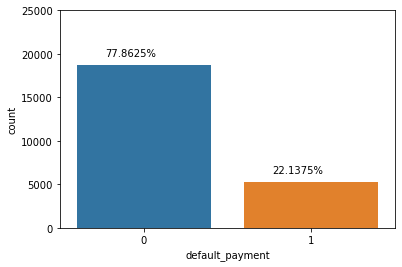

In [8]:
plt.figure(figsize=(6,4))

default_plot = sns.countplot(x = "default_payment",data = train_df)
plt.ylim(0,25000)
total = float(len(train_df))
for p in default_plot.patches:
    default_plot.annotate((str(100* p.get_height()/total) + "%"), (p.get_x()+0.32, p.get_height()+1000), ha="center")


plt.show()



The above plot shows the percentage of rows with default payment = 0 versus default payment = 1. Cleary there is class imbalance in this dataset. Because of this, we will use the area under the Receiver Operating Characterisitc curve (ROC AUC) as our primary metric to evaluate our model instead of accuracy, which tends to be missleading in cases of class imbalance. ROC AUC evalauates how good the model is as distinguishing between classes, and gives a more accurate sense of how well our model generalizes when dealing with class imbalance.

### Preprossesing 

We apply scaling to numeric features to ensure the model built will be robust and not sensitive to the scale of each individual feature. To do this, we use the StandardScaler() function to set the sample mean to 0 and standard deviation to 1.

To handle categorical values, we will apply one-hot-encoding. This creates binary dummy variables for each category. 

There are no null values in the dataset so there is no need to handle missing values. 

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 4680 to 3970
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               24000 non-null  int64
 1   LIMIT_BAL        24000 non-null  int64
 2   SEX              24000 non-null  int64
 3   EDUCATION        24000 non-null  int64
 4   MARRIAGE         24000 non-null  int64
 5   AGE              24000 non-null  int64
 6   PAY_0            24000 non-null  int64
 7   PAY_2            24000 non-null  int64
 8   PAY_3            24000 non-null  int64
 9   PAY_4            24000 non-null  int64
 10  PAY_5            24000 non-null  int64
 11  PAY_6            24000 non-null  int64
 12  BILL_AMT1        24000 non-null  int64
 13  BILL_AMT2        24000 non-null  int64
 14  BILL_AMT3        24000 non-null  int64
 15  BILL_AMT4        24000 non-null  int64
 16  BILL_AMT5        24000 non-null  int64
 17  BILL_AMT6        24000 non-null  int64
 18  PAY_

In [12]:
numeric_feats = [     # apply scaling
    "LIMIT_BAL",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4", 
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "AGE",
]

categorical_feats = [  # apply one-hot encoding
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "EDUCATION",
    "SEX",
    "MARRIAGE",
]

Next, we apply scaling and one-hot-encoding through using a column transformer, which applies the transformations to each column specified. 

In [14]:
ct = make_column_transformer(
    (StandardScaler(), numeric_feats,),
    (OneHotEncoder(handle_unknown="ignore"), categorical_feats,),

)

### Baseline Model

Firstly, we will try a baseline model to act as a comparison measure for the final model built. Using a pipeline to do this ensures that the model is built using just the training data, and that the testing data has no influence on the model. 5-fold Cross validation is used to give a more robust measure of performance error. K-fold Cross-validation spilts the training data into k folds, and each time one fold is the validation set. Each fold fits the model on the training portion and uses one fold as a validation set to calculate a performance metric, which can be averaged to get a overall score of how well the model does. This ensures that outliers don't negatively influence the performance metric. 

In [16]:
from sklearn.model_selection import cross_val_predict

dummy = DummyClassifier()

pipe = make_pipeline(ct, dummy)

scores = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5, scoring="roc_auc")
scores = pd.DataFrame(scores)
scores

,fit_time,score_time,test_score,train_score
0,0.080761,0.014796,0.5,0.5
1,0.045071,0.014051,0.5,0.5
2,0.050334,0.014921,0.5,0.5
3,0.046529,0.014421,0.5,0.5
4,0.044651,0.014352,0.5,0.5


### Logistic Regression

Next, a logistic regression model is fitted to the training data. Logistic regression uses the training data to learn coefficients, which then can be used to calculate prediction probabilities of the each class using the sigmoid function. This allows us to calculate the likelihood of a person defaulting on their credit card. The hyperparameter C is used to control the fundatamental tradeoff of bias and variance, to reduce the likeliness of the model overfitting or underfitting. 

In [22]:
random.seed()

train_scores = []
cv_scores = []

C = 10.0 ** np.arange(-1.5, 2, 0.5)

for c in C:
    
    pipe_lr = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=c),
    )
    
    results = cross_validate(pipe_lr, X_train, y_train, return_train_score=True, scoring = "roc_auc")
    
    train_scores.append(results["train_score"].mean())
    cv_scores.append(results["test_score"].mean())
    

scores = pd.DataFrame({"C": C, "Train Scores": train_scores, "CV Scores": cv_scores })

scores


,C,Train Scores,CV Scores
0,0.031623,0.772838,0.769484
1,0.100000,0.773099,0.769361
2,0.316228,0.773205,0.769095
3,1.000000,0.773281,0.768788
4,3.162278,0.773344,0.768452
5,10.000000,0.773407,0.768063
6,31.622777,0.773459,0.767816


In [25]:
best_C = scores.loc[scores["CV Scores"].idxmax(), "C"]
print("best C value: " + str(best_C))

best C value: 0.03162277660168379
